In [16]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from torch_geometric.data import Data
import torch
import os
from rdkit.Chem import Draw


In [17]:
url = "https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/delaney-processed.csv"
df = pd.read_csv(url)
df = df[['smiles', 'measured log solubility in mols per litre']]
df.columns = ['smiles', 'solubility']

df.head()

,smiles,solubility
0,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...,-0.77
1,Cc1occc1C(=O)Nc2ccccc2,-3.30
2,CC(C)=CCCC(C)=CC(=O),-2.06
3,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43,-7.87
4,c1ccsc1,-1.33


In [19]:
from torch_geometric.data import InMemoryDataset
from torch_geometric.utils import from_networkx
import networkx as nx


In [51]:
def get_atom_features(atom):
    return [
        atom.GetAtomicNum(),            
        atom.GetDegree(),               
        atom.GetFormalCharge(),         
        atom.GetHybridization().real,   
        int(atom.GetIsAromatic()),      
        atom.GetTotalNumHs()            
    ]

def mol_to_graph_data_obj(smiles, label):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    atom_feats = [get_atom_features(atom) for atom in mol.GetAtoms()]
    edge_index = []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        edge_index.append([i, j])
        edge_index.append([j, i])

    x = torch.tensor(atom_feats, dtype=torch.float)
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    y = torch.tensor([label], dtype=torch.float)

    return Data(x=x, edge_index=edge_index, y=y)


In [52]:
graph_list = []
for i, row in df.iterrows():
    data = mol_to_graph_data_obj(row['smiles'], row['solubility'])
    if data:
        graph_list.append(data)

print(f"✅ Converted {len(graph_list)} molecules to graphs.")

✅ Converted 1128 molecules to graphs.


In [53]:
from sklearn.model_selection import train_test_split
from torch_geometric.loader import DataLoader

train_data, test_data = train_test_split(graph_list, test_size=0.2, random_state=42)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)


In [54]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool

class GCN(nn.Module):
    def __init__(self, num_node_features, hidden_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.lin = nn.Linear(hidden_channels, 1)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = global_mean_pool(x, batch)
        x = self.lin(x)
        return x


In [55]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(num_node_features=6, hidden_channels=64).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

def train():
    model.train()
    total_loss = 0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index, batch.batch)
        loss = criterion(out.view(-1), batch.y.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

def test(loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index, batch.batch)
            loss = criterion(out.view(-1), batch.y.view(-1))
            total_loss += loss.item()
    return total_loss / len(loader)


In [57]:
for epoch in range(1, 201):
    train_loss = train()
    test_loss = test(test_loader)
    if epoch % 10 == 0:
        print(f'Epoch {epoch:03d} | Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f}')


Epoch 010 | Train Loss: 1.4550 | Test Loss: 1.8349
Epoch 020 | Train Loss: 1.4649 | Test Loss: 1.4068
Epoch 030 | Train Loss: 1.3513 | Test Loss: 1.5698
Epoch 040 | Train Loss: 1.3066 | Test Loss: 1.3919
Epoch 050 | Train Loss: 1.3643 | Test Loss: 1.7367
Epoch 060 | Train Loss: 1.5238 | Test Loss: 2.8012
Epoch 070 | Train Loss: 1.2739 | Test Loss: 1.4725
Epoch 080 | Train Loss: 1.2683 | Test Loss: 1.2648
Epoch 090 | Train Loss: 1.1945 | Test Loss: 1.3508
Epoch 100 | Train Loss: 1.2030 | Test Loss: 1.3730
Epoch 110 | Train Loss: 1.3164 | Test Loss: 1.4238
Epoch 120 | Train Loss: 1.3259 | Test Loss: 1.3440
Epoch 130 | Train Loss: 1.1900 | Test Loss: 1.2681
Epoch 140 | Train Loss: 1.2925 | Test Loss: 1.2752
Epoch 150 | Train Loss: 1.1928 | Test Loss: 1.2921
Epoch 160 | Train Loss: 1.3583 | Test Loss: 1.2962
Epoch 170 | Train Loss: 1.1688 | Test Loss: 1.8564
Epoch 180 | Train Loss: 1.1918 | Test Loss: 1.4362
Epoch 190 | Train Loss: 1.0618 | Test Loss: 1.3478
Epoch 200 | Train Loss: 1.0439 

📉 RMSE: 1.2371
📈 R² Score: 0.6762


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


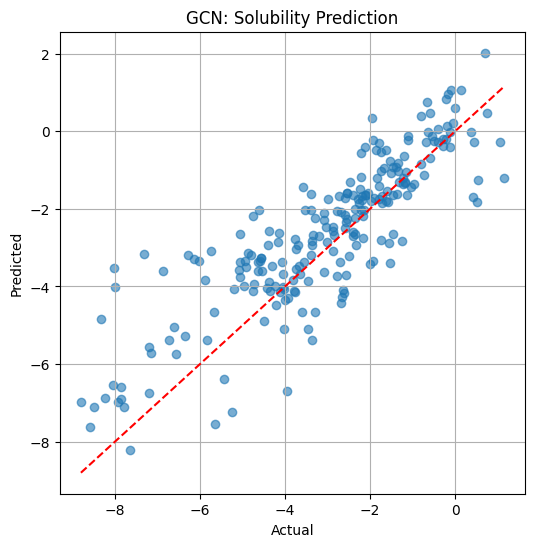

In [58]:
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        out = model(batch.x, batch.edge_index, batch.batch)
        y_true.extend(batch.y.view(-1).cpu().numpy())
        y_pred.extend(out.view(-1).cpu().numpy())

rmse = mean_squared_error(y_true, y_pred, squared=False)
r2 = r2_score(y_true, y_pred)

print(f"📉 RMSE: {rmse:.4f}")
print(f"📈 R² Score: {r2:.4f}")

# Plot
plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred, alpha=0.6)
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("GCN: Solubility Prediction")
plt.grid(True)
plt.show()


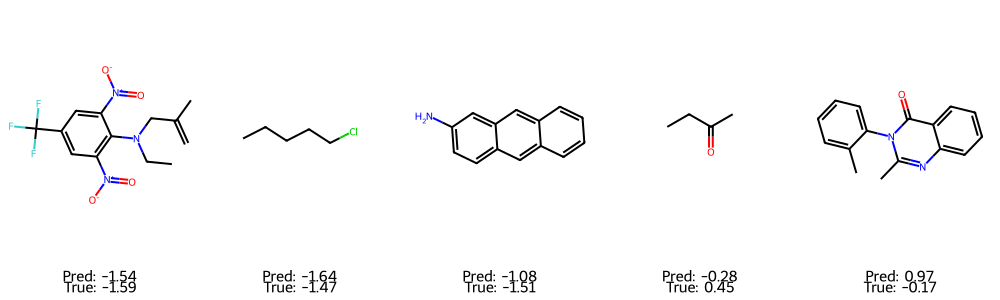

In [63]:
from rdkit.Chem import Draw

# Get original SMILES strings from the DataFrame
sample_indices = [test_data.index(m) for m in samples]
smiles_subset = [df.iloc[i]['smiles'] for i in sample_indices]
mols = [Chem.MolFromSmiles(smi) for smi in smiles_subset]

# Annotate molecules with prediction results
legends = [f"Pred: {pred:.2f}\nTrue: {true:.2f}" for pred, true in predictions]

# Plot side-by-side
Draw.MolsToGridImage(mols, legends=legends, molsPerRow=5, subImgSize=(200, 300))


In [65]:
torch.save(model.state_dict(), 'gcn_esol_model.pt')
